In [85]:
import pandas as pd
import os

# sckit-learn
from sklearn.model_selection import train_test_split


import imblearn

# Viz packages
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [67]:
# MACRO VARIABLES

INPUT_DIR = '../inputs/'

INPUT_DATA = 'dados.csv'

# Out of time length in days
OFT_LEN = 7

# Train Test Size

TRAIN_TEST_LEN = 0.3

# RANDOM STATE
SEED = 395

YNAME = 'fraude'

#### Import Data

In [23]:
original_df = pd.read_csv(os.path.join(INPUT_DIR, INPUT_DATA), decimal='.')
original_df.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,fecha,monto,score,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0


#### Train, Test and Out-Of-Time samples

In [51]:
# It seems that 'fecha' is the date that the operation occured, so I'll use it to create a out-of-time sample
# First it needed to be converted to a date format
df = original_df.copy()

df['oper_date'] = pd.to_datetime(df['fecha'])

# Year-Month
df['oper_YM'] = df['oper_date'].apply(lambda x: x.year * 100 + x.month )

# Year-Month-Day
df['oper_YMD'] = df['oper_date'].apply(lambda x: (x.year * 100 + x.month)*100 + x.day  )


In [52]:
check_YM_dist = df.groupby('oper_YM').agg(qt=('fecha', len))
check_YM_dist

# The data has only a sample of 2 months, so its not gonna be a good choice to split a out-of time sample based on month 

,qt
oper_YM,
202003,76961
202004,73039


20200421


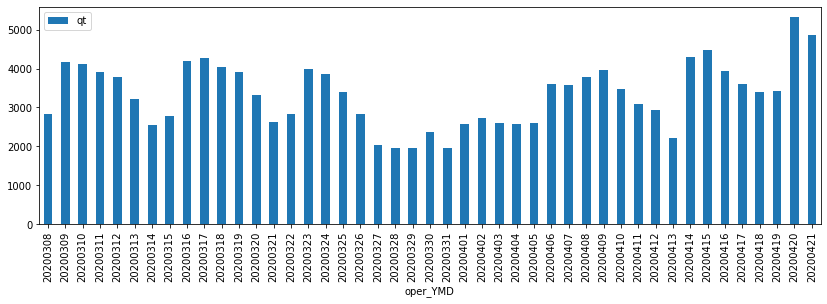

In [56]:
check_YMD_dist = df.groupby('oper_YMD').agg(qt=('fecha', len))
check_YMD_dist.plot(kind='bar', figsize=(14,4))

# The out-of-sample will be of 7 days(1 week), it ill be set on macro variables cell.

In [64]:
# Split out of time sample

__OutOfTimeMax__ = df['oper_date'].max()
__OutOfTimeMin__ = __OutOfTimeMax__ + pd.offsets.DateOffset(days=-OFT_LEN)

# This is the dataset tha will be used to evaluate the model
outoftime = df.loc[df['oper_date'] >= __OutOfTimeMin__, :]

In [70]:
# Create y and X

traintest = df.loc[df['oper_date'] < __OutOfTimeMin__, :]

y =  traintest[YNAME]

__colstodrop__ = ['fecha', 'monto', 'score', 'fraude', 'oper_date', 'oper_YM', 'oper_YMD']
X = traintest.drop(columns=__colstodrop__)


In [72]:
# Split in train test samples

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TRAIN_TEST_LEN, random_state=SEED)

#### Univariate Analysis

It's commom to observe imbalanced dataset for fraud detection problems.
If it's not handle properly it could result in a misleading model, where the accuracy is high because is more likely that the model will classify all events as a non-fraud.
In a model lije that will be a great amount of losses.

In [93]:
print('fraud_rate {:.3%}'.format(y_train.sum() / len(y_train)))

# With this rate I've opted for oversampling

fraud_rate 5.145%


In [90]:
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority', random_state=SEED)

In [91]:
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

In [111]:
print(' New fraud_rate {:.3%}'.format(y_train_OS.sum() / len(y_train_OS)))


 New fraud_rate 50.000%


<AxesSubplot:>

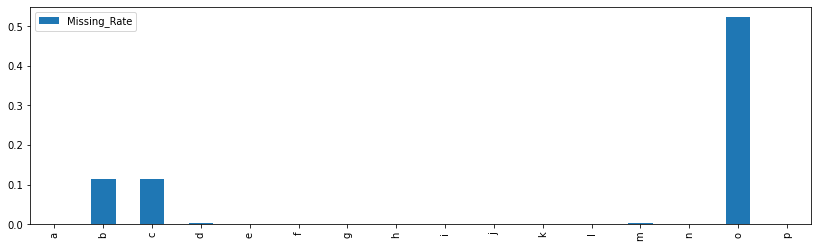

In [117]:
# Handle Missing Data
missing_freq = pd.DataFrame(X_train_OS.isna().sum() / X_train_OS.isna().count(), columns='Missing_Rate'.split())
missing_freq.plot(kind='bar', figsize=(14,4))

# Missing data will be replaced by a different category in each variable
# I haven't chosen to replace misssing by the mean/meadian of the variable, because in most cases, creating another category for the missing date has more 4explaining power.
# Column 'o' has more than 50% of its observation missing, maybe its a good choice to remove from the model